# Comparing Integrated Gradients and Activation Patching



## Set up


We load a pre-trained toy transformer which performs balanced bracket classification. 

Important note: the final classification for whether the sequence is balanced or not comes from position 0 of the output (all other outputs are discarded).

<img src="reference/bracket-transformer-entire-model-short.png" alt="Transformer architecture" width="50%"/>

In [2]:
import importlib

import torch
from captum.attr import LayerIntegratedGradients
import numpy as np
from transformer_lens.utils import get_act_name
from transformer_lens import ActivationCache
from transformer_lens.hook_points import HookPoint

import toy_transformers.toy_bracket_transformer as tt
importlib.reload(tt)
from toy_transformers.toy_bracket_transformer import load_toy_bracket_transformer, test_loaded_bracket_model

import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
tokenizer, model = load_toy_bracket_transformer()

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (hook_tokens): HookPoint()
  (blocks): ModuleList(
    (0-2): 3 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out):

## Integrated gradients

We need to choose an appropriate baseline to calculate Integrated Gradients from. An ideal baseline input will produce a final output which is close to zero, and meaningfully represents a lack of information (see Sundararajan et al. 2017). 

Here we test a series of inputs which are feasible baseline inputs, and check their final classification scores. The `[START, PAD, END]` token sequence with zero patching on target components seems to be the best baseline, because it produces a final output which is consistently closest to zero, and this sequence meaningfully represents an input with no information.

In [4]:
# The prediction at the baseline should be near zero (see Sundararajan et al. 2017)
# Here we test a series of inputs which could be a baseline, and check their final classification scores

def predict_balanced(x):
    logits = model(x)[:, 0]
    return logits.softmax(-1)[:, 1]

balanced_input = tokenizer.tokenize("()()")
print("Input:", balanced_input)
print(predict_balanced(balanced_input), "\n")

unbalanced_input = tokenizer.tokenize("(()(")
print("Input:", unbalanced_input)
print(predict_balanced(unbalanced_input), "\n")

all_padding = torch.full_like(balanced_input, tokenizer.PAD_TOKEN)
print("Input:", all_padding)
print(predict_balanced(all_padding), "\n")

mask = np.isin(balanced_input, [tokenizer.START_TOKEN, tokenizer.END_TOKEN])
start_pad_end = balanced_input * mask + tokenizer.PAD_TOKEN * (1 - mask)
print("Input:", start_pad_end)
print(predict_balanced(start_pad_end), "\n")

all_zeroes = torch.zeros_like(balanced_input)
print("Input:", all_zeroes)
print(predict_balanced(all_zeroes), "\n")


def patch_zero_hook(activations: torch.Tensor, hook: HookPoint):
    # Replace activations with zeroes
    activations = torch.zeros_like(activations)
    return activations

with model.hooks(fwd_hooks=[("blocks.0.hook_mlp_out", patch_zero_hook)]):
    print("Patch zeroes in at target component")
    print(predict_balanced(balanced_input))
    print(predict_balanced(unbalanced_input))
    print(predict_balanced(all_padding))
    print(predict_balanced(start_pad_end))
    print(predict_balanced(all_zeroes))
    

Input: tensor([[0, 3, 4, 3, 4, 2]])
tensor([1.0000], grad_fn=<SelectBackward0>) 

Input: tensor([[0, 3, 3, 4, 3, 2]])
tensor([1.8627e-05], grad_fn=<SelectBackward0>) 

Input: tensor([[1, 1, 1, 1, 1, 1]])
tensor([0.0411], grad_fn=<SelectBackward0>) 

Input: tensor([[0, 1, 1, 1, 1, 2]])
tensor([3.6777e-06], grad_fn=<SelectBackward0>) 

Input: tensor([[0, 0, 0, 0, 0, 0]])
tensor([1.5444e-05], grad_fn=<SelectBackward0>) 

Patch zeroes in at target component
tensor([0.0074], grad_fn=<SelectBackward0>)
tensor([6.3960e-05], grad_fn=<SelectBackward0>)
tensor([0.0172], grad_fn=<SelectBackward0>)
tensor([1.0772e-05], grad_fn=<SelectBackward0>)
tensor([1.5005e-05], grad_fn=<SelectBackward0>)


In [5]:
def patch_zero_hook(activations: torch.Tensor, hook: HookPoint):
    # Replace activations with zeroes
    activations = torch.zeros_like(activations)
    return activations


def patch_zero_forward_fn(x, baseline, target_layer):
    if torch.equal(x, baseline):
        # Patch zeros into target layer when baseline measurement is given
        output = model.run_with_hooks(x, fwd_hooks=[(target_layer.name, patch_zero_hook)])
    else:
        output = model(x)
    logits = output[:, 0]
    return logits.softmax(-1)[:, 1]


def compute_layer_to_output_attributions(input, target_layer, baseline):
    forward_fn = lambda x: patch_zero_forward_fn(x, baseline, target_layer)
    ig_embed = LayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
    # Calculate layer integrated gradients for class 0 (unbalanced),
    attributions, approximation_error = ig_embed.attribute(inputs=input,
                                                    baselines=baseline,
                                                    attribute_to_layer_input=False,
                                                    return_convergence_delta=True)
    print(f"\nError (delta) for {target_layer.name} attribution: {approximation_error.item()}")
    return attributions

In [6]:
# Gradient attribution for neurons in MLP layers
mlp_ig_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Gradient attribution for attention heads
attn_ig_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

# Calculate integrated gradients for each layer
input = tokenizer.tokenize("()()")
mask = np.isin(input, [tokenizer.START_TOKEN, tokenizer.END_TOKEN])
baseline = input * mask + tokenizer.PAD_TOKEN * (1 - mask)

for layer in range(model.cfg.n_layers):
    # Gradient attribution on heads
    hook_name = get_act_name("result", layer)
    target_layer = model.hook_dict[hook_name]
    attributions = compute_layer_to_output_attributions(input, target_layer, baseline) # shape [1, seq_len, d_head, d_model]
    # Calculate attribution score based on mean over each embedding, for each token
    per_token_score = attributions.mean(dim=3)
    score = per_token_score.mean(dim=1)
    attn_ig_results[layer] = score

    # Gradient attribution on MLP neurons
    target_layer = model.blocks[layer].hook_mlp_out
    attributions = compute_layer_to_output_attributions(input, target_layer, baseline) # shape [1, seq_len, d_model]
    score = attributions.mean(dim=1)
    mlp_ig_results[layer] = score


Error (delta) for blocks.0.attn.hook_result attribution: -0.06375384330749512

Error (delta) for blocks.0.hook_mlp_out attribution: -0.0021299123764038086

Error (delta) for blocks.1.attn.hook_result attribution: -0.12871885299682617

Error (delta) for blocks.1.hook_mlp_out attribution: -0.019762754440307617

Error (delta) for blocks.2.attn.hook_result attribution: 0.0016323328018188477

Error (delta) for blocks.2.hook_mlp_out attribution: -0.9999805688858032


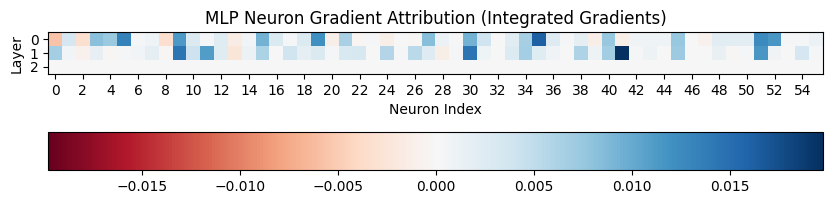

In [7]:
bound = max(torch.max(mlp_ig_results), abs(torch.min(mlp_ig_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_ig_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients)")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

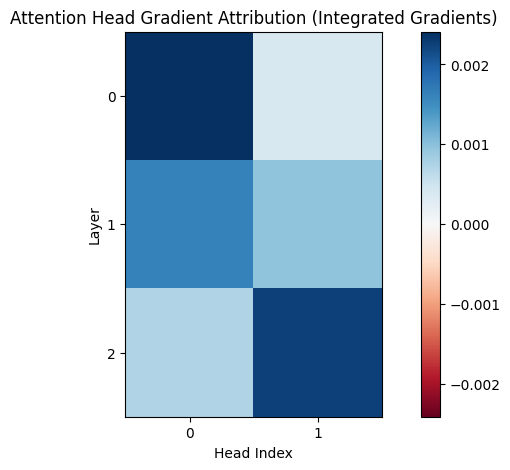

In [8]:
bound = max(torch.max(attn_ig_results), abs(torch.min(attn_ig_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_ig_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Integrated Gradients)")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

### Comparison: unbalanced input sequence

Repeat with unbalanced sequence for comparison.

In [9]:
# Gradient attribution for neurons in MLP layers
mlp_ig_unbalanced_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Gradient attribution for attention heads
attn_ig_unbalanced_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

# Calculate integrated gradients for each layer
input = tokenizer.tokenize("(()(")
mask = np.isin(input, [tokenizer.START_TOKEN, tokenizer.END_TOKEN])
baseline = input * mask + tokenizer.PAD_TOKEN * (1 - mask)

for layer in range(model.cfg.n_layers):
    # Gradient attribution on heads
    hook_name = get_act_name("result", layer)
    target_layer = model.hook_dict[hook_name]
    attributions = compute_layer_to_output_attributions(input, target_layer, baseline)
    # Calculate attribution score based on mean over each embedding, for each token
    per_token_score = attributions.mean(dim=3)
    score = per_token_score.mean(dim=1)
    attn_ig_unbalanced_results[layer] = score

    # Gradient attribution on MLP neurons
    target_layer = model.blocks[layer].hook_mlp_out
    attributions = compute_layer_to_output_attributions(input, target_layer, baseline)
    score = attributions.mean(dim=1)
    mlp_ig_unbalanced_results[layer] = score


Error (delta) for blocks.0.attn.hook_result attribution: 2.431000211799983e-05

Error (delta) for blocks.0.hook_mlp_out attribution: -7.003468454058748e-06

Error (delta) for blocks.1.attn.hook_result attribution: 2.229996425739955e-06

Error (delta) for blocks.1.hook_mlp_out attribution: -1.0247405953123234e-05

Error (delta) for blocks.2.attn.hook_result attribution: 0.0020253800321370363

Error (delta) for blocks.2.hook_mlp_out attribution: -1.7768754332792014e-05


Gradient attribution scores for MLP neurons do not depend on whether the sequence is balanced or unbalanced. This suggests that the MLP neurons may be involved in some universal processing of information, used downstream for final output classification.

Gradient attribution scores for attention heads change when the sequence is unbalanced. Notably, head 2.1 contributes significantly more highly to a positive "unbalanced" classification. This suggests that head 2.1 plays a strong role in the final output. The attribution scores for the other attention heads are less strong, suggesting a weaker role.

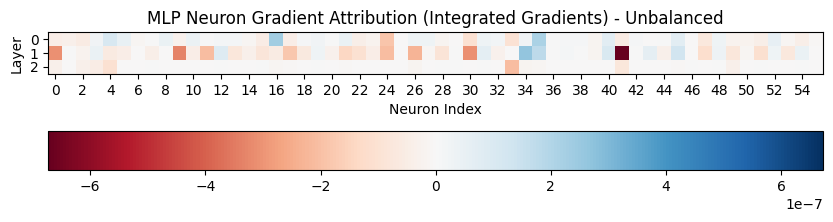

In [10]:
bound = max(torch.max(mlp_ig_unbalanced_results), abs(torch.min(mlp_ig_unbalanced_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_ig_unbalanced_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients) - Unbalanced")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

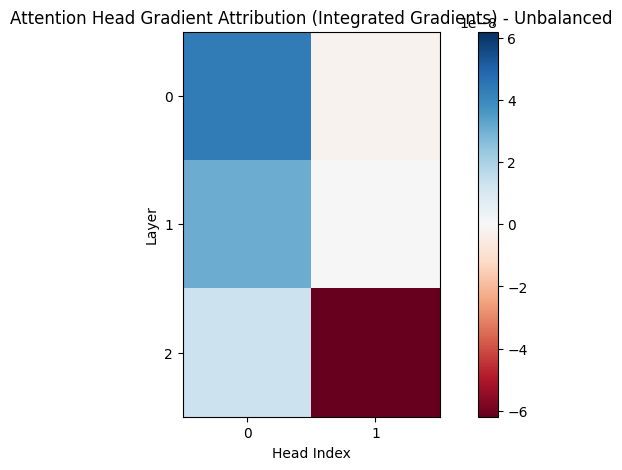

In [11]:
bound = max(torch.max(attn_ig_unbalanced_results), abs(torch.min(attn_ig_unbalanced_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_ig_unbalanced_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Integrated Gradients) - Unbalanced")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

### Comparison: empty string attributions

In [12]:
# Gradient attribution for neurons in MLP layers
mlp_ig_empty_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Gradient attribution for attention heads
attn_ig_empty_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

# Calculate integrated gradients for each layer
input = tokenizer.tokenize("")
mask = np.isin(input, [tokenizer.START_TOKEN, tokenizer.END_TOKEN])
baseline = input * mask + tokenizer.PAD_TOKEN * (1 - mask)

for layer in range(model.cfg.n_layers):
    # Gradient attribution on heads
    hook_name = get_act_name("result", layer)
    target_layer = model.hook_dict[hook_name]
    attributions = compute_layer_to_output_attributions(input, target_layer, baseline)
    # Calculate attribution score based on mean over each embedding, for each token
    per_token_score = attributions.mean(dim=3)
    score = per_token_score.mean(dim=1)
    attn_ig_empty_results[layer] = score

    # Gradient attribution on MLP neurons
    target_layer = model.blocks[layer].hook_mlp_out
    attributions = compute_layer_to_output_attributions(input, target_layer, baseline)
    score = attributions.mean(dim=1)
    mlp_ig_empty_results[layer] = score


Error (delta) for blocks.0.attn.hook_result attribution: 0.0

Error (delta) for blocks.0.hook_mlp_out attribution: 0.0

Error (delta) for blocks.1.attn.hook_result attribution: 0.0

Error (delta) for blocks.1.hook_mlp_out attribution: 0.0

Error (delta) for blocks.2.attn.hook_result attribution: 0.0

Error (delta) for blocks.2.hook_mlp_out attribution: 0.0


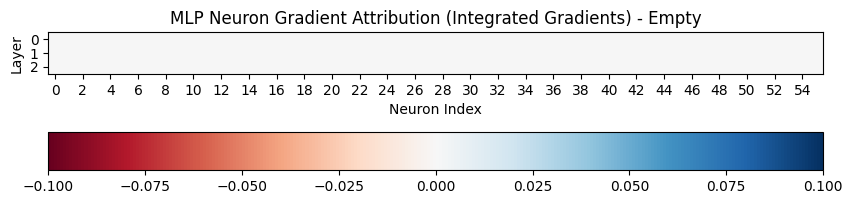

In [13]:
bound = max(torch.max(mlp_ig_empty_results), abs(torch.min(mlp_ig_empty_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_ig_empty_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients) - Empty")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

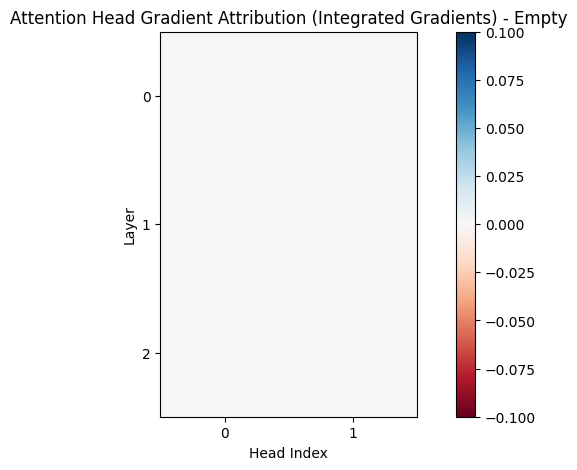

In [14]:
bound = max(torch.max(attn_ig_empty_results), abs(torch.min(attn_ig_empty_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_ig_empty_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Integrated Gradients) - Empty")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

## Causal tracing

Noising (a corrupt → clean patch) shows whether the patched activations were *necessary* to maintain the model behaviour. Therefore we patch corrupted activations into a clean run.

In [15]:
from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens.hook_points import HookPoint

clean_input = tokenizer.tokenize("()()")        # Balanced
corrupted_input = tokenizer.tokenize("(()(")    # Unbalanced

# We run on the corrupted prompt with the cache so we store activations to patch in later.
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_input)
clean_logits = model(clean_input)

# Get probability of overall sequence being balanced (class 1) from position 0
clean_answer_logits = clean_logits[0, 0, 1]
corrupted_answer_logits = corrupted_logits[0, 0, 1]
print(f"Balanced input score: {clean_answer_logits}")
print(f"Unbalanced input score: {corrupted_answer_logits}")

baseline_diff = (corrupted_answer_logits - clean_answer_logits).item()
print(f"Baseline clean-corrupted logit difference: {baseline_diff:.2f}")

Balanced input score: 5.693811416625977
Unbalanced input score: -5.421151161193848
Baseline clean-corrupted logit difference: -11.11


In [16]:
# Patch neurons in MLP layers
mlp_patch_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Patch attention heads
attn_patch_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

def patch_neuron_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, neuron_idx: int):
    # Replace the activations for the target neuron with activations from the cached run.
    cached_activations = cache[hook.name]
    activations[:, :, neuron_idx] = cached_activations[:, :, neuron_idx]
    return activations

def patch_attn_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, head_idx: int):
    # Replace the activations for the target attention head with activations from the cached run.
    cached_activations = cache[hook.name]
    activations[:, :, head_idx, :] = cached_activations[:, :, head_idx, :]
    return activations


for layer in range(model.cfg.n_layers):
    # Activation patching on heads
    for head in range(model.cfg.n_heads):
        hook_name = get_act_name("result", layer)
        temp_hook = lambda act, hook: patch_attn_hook(act, hook, corrupted_cache, head)

        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(clean_input)

        patched_answer_logits = patched_logits[0, 0, 1]
        logit_diff = (patched_answer_logits - clean_answer_logits).item()
        # Normalise result by clean and corrupted logit difference
        attn_patch_results[layer, head] = logit_diff / baseline_diff

    # Activation patching on MLP neurons
    for neuron in range(model.cfg.d_mlp):
        hook_name = get_act_name("mlp_out", layer)
        temp_hook = lambda act, hook: patch_neuron_hook(act, hook, corrupted_cache, neuron)
        
        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(clean_input)

        patched_answer_logits = patched_logits[0, 0, 1]
        logit_diff = (patched_answer_logits - clean_answer_logits).item()
        # Normalise result by clean and corrupted logit difference
        mlp_patch_results[layer, neuron] = logit_diff / baseline_diff

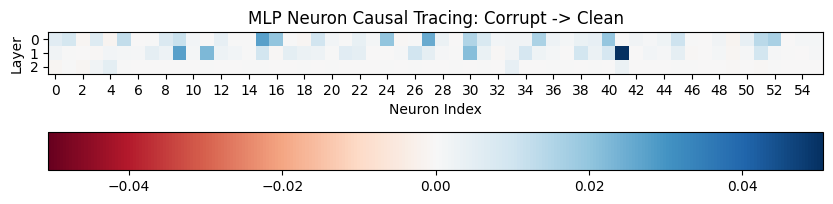

In [17]:
bound = max(torch.max(mlp_patch_results), abs(torch.min(mlp_patch_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_patch_results, cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Causal Tracing: Corrupt -> Clean")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

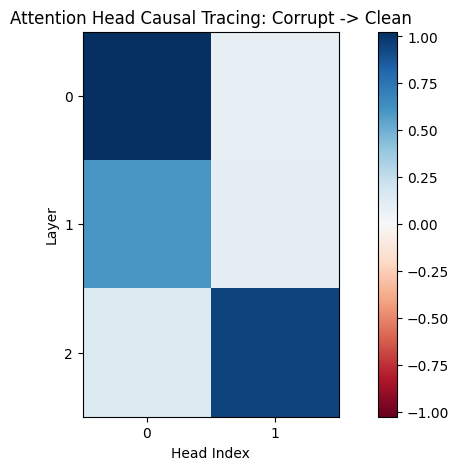

In [18]:
bound = max(torch.max(attn_patch_results), abs(torch.min(attn_patch_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_patch_results, cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Causal Tracing: Corrupt -> Clean")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

### Comparison: patching in the opposite direction (denoising)

In [19]:
from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens.hook_points import HookPoint

clean_input = tokenizer.tokenize("()()")        # Balanced
corrupted_input = tokenizer.tokenize("(()(")    # Unbalanced

# We run on the clean prompt with the cache so we store activations to patch in later.
clean_logits, clean_cache = model.run_with_cache(clean_input)
corrupted_logits = model(corrupted_input)

# Get probability of overall sequence being balanced (class 1) from position 0
clean_answer_logits = clean_logits[0, 0, 1]
corrupted_answer_logits = corrupted_logits[0, 0, 1]
print(f"Balanced input score: {clean_answer_logits}")
print(f"Unbalanced input score: {corrupted_answer_logits}")

baseline_diff = (corrupted_answer_logits - clean_answer_logits).item()
print(f"Baseline clean-corrupted logit difference: {baseline_diff:.2f}")

Balanced input score: 5.693811416625977
Unbalanced input score: -5.421151161193848
Baseline clean-corrupted logit difference: -11.11


In [20]:
# Patch neurons in MLP layers
mlp_patch_denoising_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Patch attention heads
attn_patch_denoising_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

for layer in range(model.cfg.n_layers):
    # Activation patching on heads
    for head in range(model.cfg.n_heads):
        hook_name = get_act_name("result", layer)
        temp_hook = lambda act, hook: patch_attn_hook(act, hook, clean_cache, head)

        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(corrupted_input)

        patched_answer_logits = patched_logits[0, 0, 1]
        logit_diff = (patched_answer_logits - corrupted_answer_logits).item()
        # Normalise result by clean and corrupted logit difference
        attn_patch_denoising_results[layer, head] = logit_diff / baseline_diff

    # Activation patching on MLP neurons
    for neuron in range(model.cfg.d_mlp):
        hook_name = get_act_name("mlp_out", layer)
        temp_hook = lambda act, hook: patch_neuron_hook(act, hook, clean_cache, neuron)
        
        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(corrupted_input)

        patched_answer_logits = patched_logits[0, 0, 1]
        logit_diff = (patched_answer_logits - corrupted_answer_logits).item()
        # Normalise result by clean and corrupted logit difference
        mlp_patch_denoising_results[layer, neuron] = logit_diff / baseline_diff

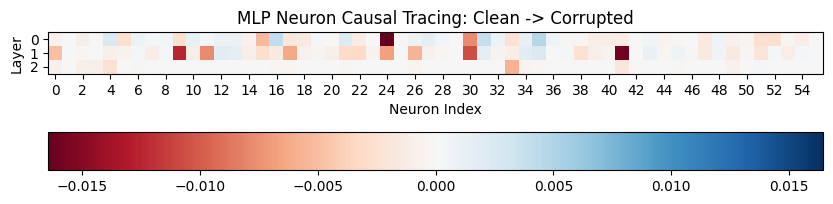

In [21]:
bound = max(torch.max(mlp_patch_denoising_results), abs(torch.min(mlp_patch_denoising_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_patch_denoising_results, cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Causal Tracing: Clean -> Corrupted")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

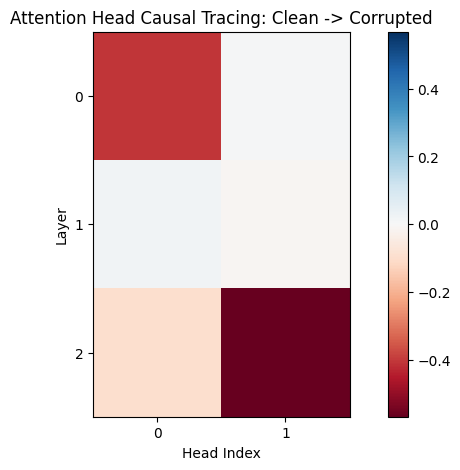

In [22]:
bound = max(torch.max(attn_patch_denoising_results), abs(torch.min(attn_patch_denoising_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_patch_denoising_results, cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Causal Tracing: Clean -> Corrupted")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

## Comparative analysis

In [23]:
mlp_ig_results = mlp_ig_results.detach()
attn_ig_results = attn_ig_results.detach()

### Correlation between attribution scores

* There is very little linear correlation between raw attribution scores for MLP neurons from Integrated Gradients and causal tracing.

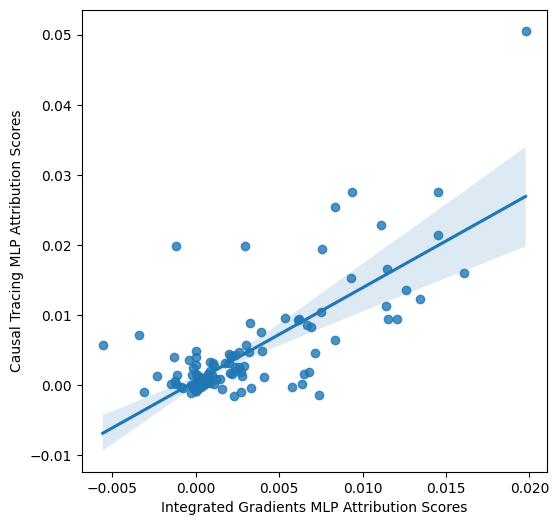

Correlation coefficient between IG and causal tracing attributions for neurons: 0.7712230344174876


In [24]:
# Plot the attribution scores against each other. Correlation: y = x.

x = mlp_ig_results.flatten().numpy()
y = mlp_patch_results.flatten().numpy()

plt.figure(figsize=(6,6))
sns.regplot(x=x, y=y)
plt.xlabel("Integrated Gradients MLP Attribution Scores")
plt.ylabel("Causal Tracing MLP Attribution Scores")
plt.show()

print(f"Correlation coefficient between IG and causal tracing attributions for neurons: {np.corrcoef(x, y)[0, 1]}")

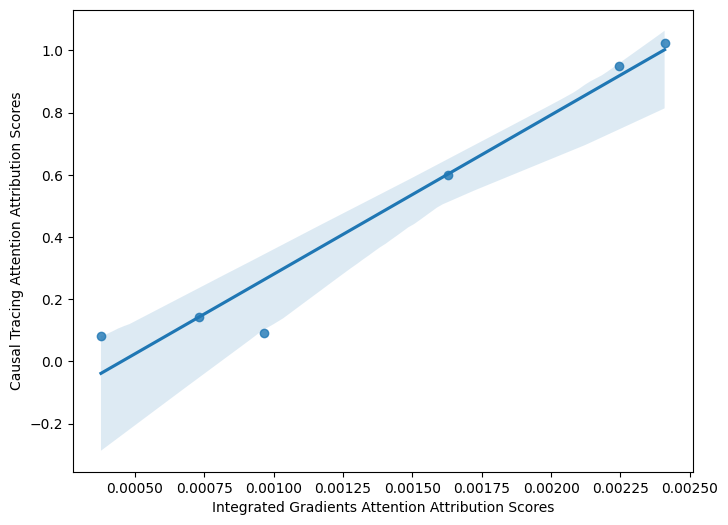

Correlation coefficient between IG and causal tracing attributions for attention: 0.9761361508593569


In [25]:
x = attn_ig_results.flatten().numpy()
y = attn_patch_results.flatten().numpy()

plt.figure(figsize=(8,6))
sns.regplot(x=x, y=y)
plt.xlabel("Integrated Gradients Attention Attribution Scores")
plt.ylabel("Causal Tracing Attention Attribution Scores")
plt.show()

print(f"Correlation coefficient between IG and causal tracing attributions for attention: {np.corrcoef(x, y)[0, 1]}")

### Agreement between attribution scores

The Jaccard scores for MLP neuron attribution scores per transformer layer is low.

In [26]:
def get_top_k_by_abs(data, k):
    _, indices = torch.topk(data.abs(), k)
    return indices, torch.gather(data, 1, indices)

def get_attributions_above_threshold(data, percentile):
    threshold = torch.min(data) + percentile * (torch.max(data) - torch.min(data))
    masked_data = torch.where(data > threshold, data, 0)
    nonzero_indices = torch.nonzero(masked_data)
    return nonzero_indices, masked_data

top_mlp_ig_indices, top_mlp_ig_results = get_attributions_above_threshold(mlp_ig_results, 0.3)
top_mlp_patch_indices, top_mlp_patch_results = get_attributions_above_threshold(mlp_patch_results, 0.3)

print(len(top_mlp_ig_indices), len(top_mlp_patch_indices))

49 12


In [27]:
# top_mlp_ig_sets = [set(row.tolist()) for row in top_mlp_ig_indices]
# top_mlp_patch_sets = [set(row.tolist()) for row in top_mlp_patch_indices]
top_mlp_ig_sets = set([tuple(t.tolist()) for t in top_mlp_ig_indices])
top_mlp_patch_sets = set([tuple(t.tolist()) for t in top_mlp_patch_indices])

intersection = top_mlp_ig_sets.intersection(top_mlp_patch_sets)
union = top_mlp_ig_sets.union(top_mlp_patch_sets)
jaccard = len(intersection) / len(union)

print(f"Jaccard score for MLP neurons: {jaccard}")

Jaccard score for MLP neurons: 0.22


In [28]:
def indices_set_to_binary_matrix(set_indices, shape):
    binary_mat = torch.zeros(shape, dtype=torch.long)
    for i, j in set_indices:
        binary_mat[i, j] = 1
    return binary_mat

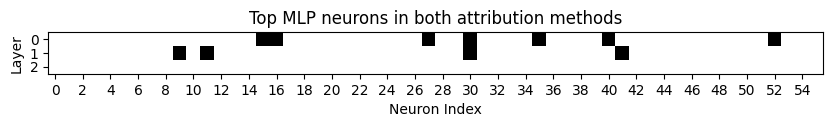

In [29]:
binary_mat_intersections = indices_set_to_binary_matrix(intersection, mlp_ig_results.shape)

plt.figure(figsize=(10, 8))
plt.imshow(binary_mat_intersections, cmap="Greys")
plt.title("Top MLP neurons in both attribution methods")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.show()

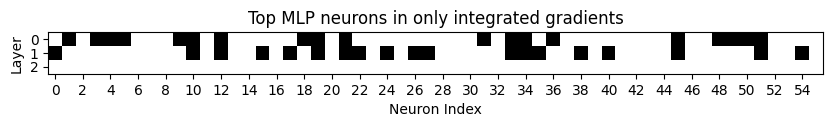

In [30]:
top_mlp_ig_exclusive = top_mlp_ig_sets.difference(top_mlp_patch_sets)

binary_mat_ig_exclusive = indices_set_to_binary_matrix(top_mlp_ig_exclusive, mlp_ig_results.shape)

plt.figure(figsize=(10, 8))
plt.imshow(binary_mat_ig_exclusive, cmap="Greys")
plt.title("Top MLP neurons in only integrated gradients")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.show()

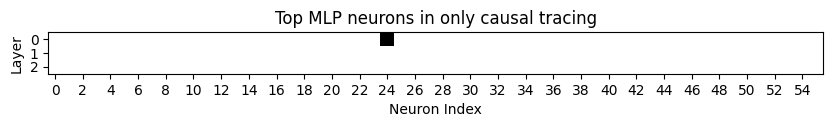

In [31]:
top_mlp_patch_exclusive = top_mlp_patch_sets.difference(top_mlp_ig_sets)

binary_mat_patch_exclusive = indices_set_to_binary_matrix(top_mlp_patch_exclusive, mlp_patch_results.shape)

plt.figure(figsize=(10, 8))
plt.imshow(binary_mat_patch_exclusive, cmap="Greys")
plt.title("Top MLP neurons in only causal tracing")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.show()

### Measuring agreement: Tukey mean-difference plot

Assumptions: the two attribution methods have the same precision, the precision is constant and does not depend on the "true" attribution score, and the difference between the two methods is constant.

NOTE: since the scales of measurement may be different, this may not be applicable.

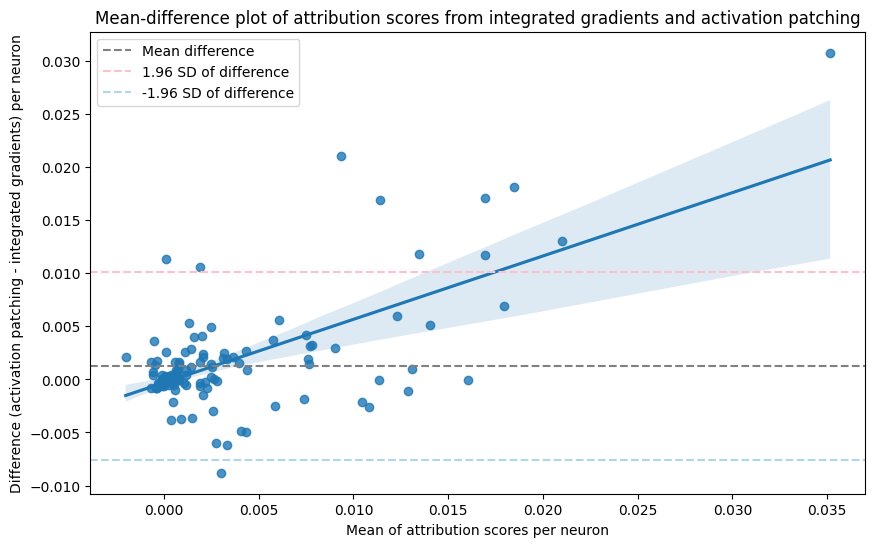

In [32]:
from sklearn.preprocessing import MaxAbsScaler

mlp_ig_results_1d = mlp_ig_results.flatten().numpy()
mlp_patch_results_1d = mlp_patch_results.flatten().numpy()

# Mean-difference plots

mean = np.mean([mlp_ig_results_1d, mlp_patch_results_1d], axis=0)
diff = mlp_patch_results_1d - mlp_ig_results_1d
md = np.mean(diff) # Mean of the difference
sd = np.std(diff, axis=0) # Standard deviation of the difference

plt.figure(figsize=(10, 6))
sns.regplot(x=mean, y=diff, fit_reg=True, scatter=True)
plt.axhline(md, color='gray', linestyle='--', label="Mean difference")
plt.axhline(md + 1.96*sd, color='pink', linestyle='--', label="1.96 SD of difference")
plt.axhline(md - 1.96*sd, color='lightblue', linestyle='--', label="-1.96 SD of difference")
plt.xlabel("Mean of attribution scores per neuron")
plt.ylabel("Difference (activation patching - integrated gradients) per neuron")
plt.title("Mean-difference plot of attribution scores from integrated gradients and activation patching")
plt.legend()
plt.show()

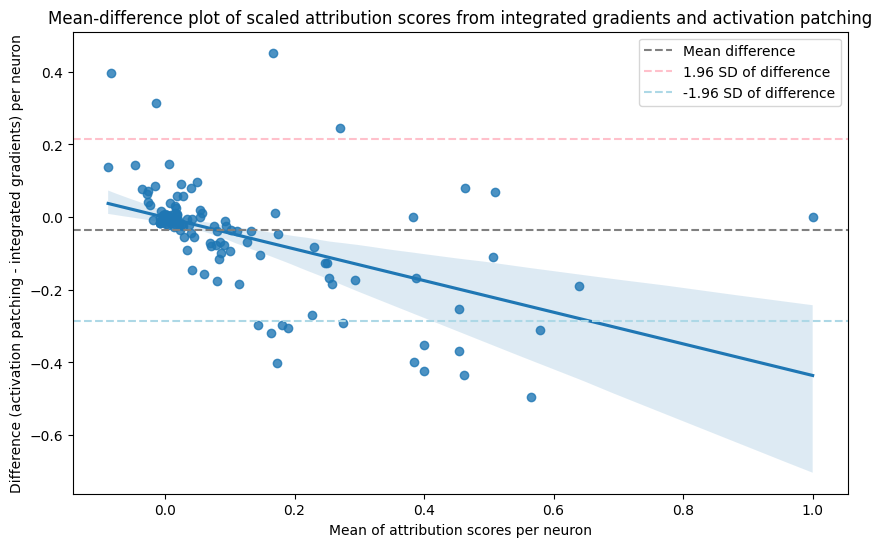

In [33]:
# Mean difference plot with scaled data

scaled_mlp_ig_results_1d = MaxAbsScaler().fit_transform(mlp_ig_results_1d.reshape(-1, 1))
scaled_mlp_patch_results_1d = MaxAbsScaler().fit_transform(mlp_patch_results_1d.reshape(-1, 1))

mean = np.mean([scaled_mlp_ig_results_1d, scaled_mlp_patch_results_1d], axis=0)
diff = scaled_mlp_patch_results_1d - scaled_mlp_ig_results_1d
md = np.mean(diff) # Mean of the difference
sd = np.std(diff, axis=0) # Standard deviation of the difference

plt.figure(figsize=(10, 6))
sns.regplot(x=mean, y=diff, fit_reg=True, scatter=True)
plt.axhline(md, color='gray', linestyle='--', label="Mean difference")
plt.axhline(md + 1.96*sd, color='pink', linestyle='--', label="1.96 SD of difference")
plt.axhline(md - 1.96*sd, color='lightblue', linestyle='--', label="-1.96 SD of difference")
plt.xlabel("Mean of attribution scores per neuron")
plt.ylabel("Difference (activation patching - integrated gradients) per neuron")
plt.title("Mean-difference plot of scaled attribution scores from integrated gradients and activation patching")
plt.legend()
plt.show()

- Mean difference is close to zero, indicating a lack of fixed bias: methods tend to agree.
- Deviation from the mean difference increases as the average attribution score increases, indicating proportional bias. Methods tend to agree on which neurons contribute less to the output, but disagree more on neurons which are identified as important by one/both of the methods. Specifically, for larger attribution scores, integrated gradients assigns greater attribution scores to neurons than causal tracing.
- The scaled limits of agreement (95% of the differences between attribution scores) lie within approximately -0.25 to 0.2. This is a fairly small but still noticeable range of error, given that the scaled attribution scores lie between -1 and 1.


### Difference in scores for attention heads

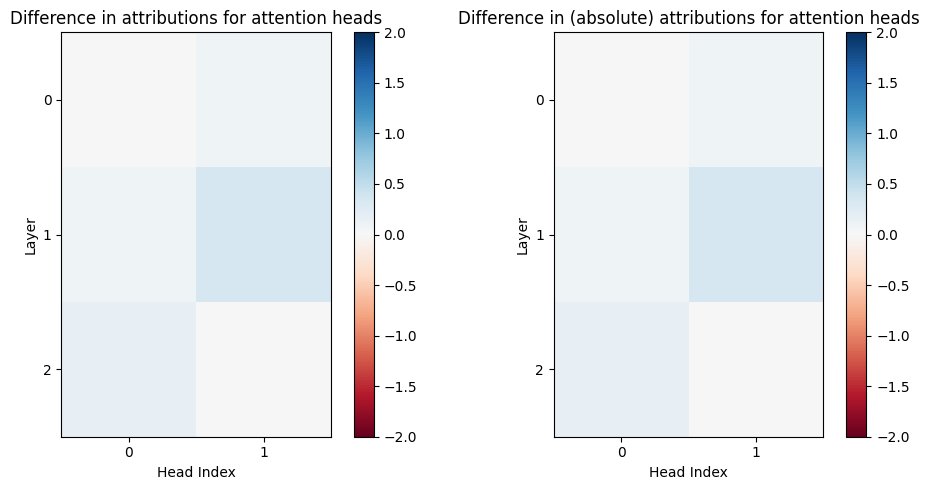

In [34]:
from sklearn.preprocessing import MaxAbsScaler

scaled_attn_ig_results = MaxAbsScaler().fit_transform(attn_ig_results)
scaled_attn_patch_results = MaxAbsScaler().fit_transform(attn_patch_results)

diff_attn_results = scaled_attn_ig_results - scaled_attn_patch_results
diff_attn_results_abs = np.abs(scaled_attn_ig_results) - np.abs(scaled_attn_patch_results)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(diff_attn_results, cmap="RdBu", vmin=-2, vmax=2)
plt.title("Difference in attributions for attention heads")

plt.xlabel("Head Index")
plt.xticks([0,1])
plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(diff_attn_results_abs, cmap="RdBu", vmin=-2, vmax=2)
plt.title("Difference in (absolute) attributions for attention heads")

plt.xlabel("Head Index")
plt.xticks([0,1])
plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.tight_layout()
plt.show()

### Comparison to "ground truth"

An in-depth investigation of the balanced bracket classifer reached the following circuit hypothesis:

- Head 0.0 allowed the first token to attend to all tokens in the sequence uniformly, and tally up `(left - right)` bracket counts.
- Neurons in MLP 0 activated when `(left - right) > 0` and neurons in MLP 1 activated when `(left - right) < 0`, and write boolean information about `left == right`.
- Head 2.0 copied information from position 1 to position 0 (which is used for the final classification).

Observations about neurons in the MLP layers which have a significant impact on the vector output in the unbalanced direction (class 0):

- Some neurons detect when the open-proportion is greater than 1/2, e.g. neurons 1.53, 1.39, 1.8 in layer 1. There are some in layer 0 as well, such as 0.33 or 0.43. Overall these seem more common in Layer 1.
- Some neurons detect when the open-proportion is less than 1/2. For instance, neurons 0.21, and 0.7. These are much more rare in layer 1, but you can see some such as 1.50 and 1.6.
- In layer 1 that there are many neurons that output a composed property (activate when proportions are imbalanced in either direction). As a few examples, look at 1.10 and 1.3. It's much harder for a single neuron in layer 0 to do this by themselves, given that ReLU is monotonic and it requires the output to be a non-monotonic function of the open-paren proportion. It is possible, however, to take advantage of the layernorm before mlp0 to approximate this -- 0.19 and 0.34 are good examples of this.
Note, there are some neurons which appear to work in the opposite direction (e.g. 0.0). It's unclear exactly what the function of these neurons is.

We identify the "true" important neurons in the MLP layers using neuron contribution plots (see tutorial ![Balanced Bracket Classifier section 3.1](reference/[1_5_1]_Balanced_Bracket_Classifier_(solutions).ipynb)). Neuron contribution is defined as the dot product (similarity) between the neuron's output vector to the residual stream, and the unbalanced direction (residual stream vector which causes highest probability for unbalanced class). Note that the tutorial only investigates the MLP neurons in the first two layers.

Using the "true" important neurons, measure the accuracy, precision, F1 and Jaccard score of each attribution method.

In [35]:
# Reference "ground truth" important neuron indices: (layer_id, neuron_idx)
reference_opposite_mlp_indices = [(0,0), (0,2), (0,20), (0,23), (0,31), (0,37), (0,38), (0,48), (0,54), (1,36), (1,38)]
reference_more_open_mlp_indices = [(0,33), (0,43), (1,8), (1,31), (1,39), (1,53)]
reference_less_open_mlp_indices = [(0,7), (0,12), (0,21), (0,50), (1,50)]
reference_composed_mlp_indices = [(0,10), (0,19), (0,34), (1,3), (1,10)]

reference_all_mlp_indices = reference_opposite_mlp_indices + reference_more_open_mlp_indices + reference_less_open_mlp_indices + reference_composed_mlp_indices

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score, confusion_matrix, ConfusionMatrixDisplay

top_mlp_ig_binary_mat = indices_set_to_binary_matrix(top_mlp_ig_indices, mlp_ig_results.shape)
top_mlp_patch_binary_mat = indices_set_to_binary_matrix(top_mlp_patch_indices, mlp_patch_results.shape)
reference_all_mlp_binary_mat = torch.zeros((2, top_mlp_ig_binary_mat.shape[1]), dtype=torch.long)
for i, j in reference_all_mlp_indices:
    reference_all_mlp_binary_mat[i,j] = 1.0


reference_all_mlp_binary_1d = reference_all_mlp_binary_mat.flatten()
top_mlp_ig_binary_1d = torch.cat((top_mlp_ig_binary_mat[0], top_mlp_ig_binary_mat[1])) # Only include first two layers to compare to ground truth
top_mlp_patch_binary_1d = torch.cat((top_mlp_patch_binary_mat[0], top_mlp_patch_binary_mat[1]))

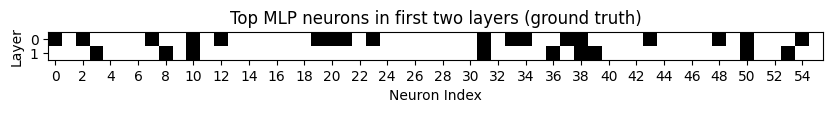

In [37]:
plt.figure(figsize=(10, 8))
plt.imshow(reference_all_mlp_binary_mat, cmap="Greys")
plt.title("Top MLP neurons in first two layers (ground truth)")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1])
plt.ylabel("Layer")
plt.show()

Integrated gradients accuracy: 0.5178571428571429
Integrated gradients precision: class 0 (low contribution) 0.746031746031746, class 1 (high contribution) 0.22448979591836735
Integrated gradients recall: class 0 (low contribution) 0.5529411764705883, class 1 (high contribution) 0.4074074074074074
Integrated gradients Jaccard score: class 0 (low contribution) 0.46534653465346537, class 1 (high contribution) 0.16923076923076924


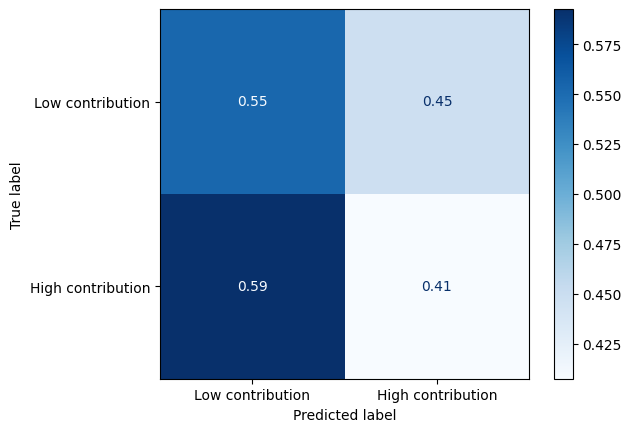

In [38]:
ig_accuracy = accuracy_score(reference_all_mlp_binary_1d, top_mlp_ig_binary_1d)
print(f"Integrated gradients accuracy: {ig_accuracy}")

ig_precision_0, ig_precision_1 = precision_score(reference_all_mlp_binary_1d, top_mlp_ig_binary_1d, average=None)
print(f"Integrated gradients precision: class 0 (low contribution) {ig_precision_0}, class 1 (high contribution) {ig_precision_1}")

ig_recall_0, ig_recall_1 = recall_score(reference_all_mlp_binary_1d, top_mlp_ig_binary_1d, average=None)
print(f"Integrated gradients recall: class 0 (low contribution) {ig_recall_0}, class 1 (high contribution) {ig_recall_1}")

ig_jaccard_0, ig_jaccard_1 = jaccard_score(reference_all_mlp_binary_1d, top_mlp_ig_binary_1d, average=None)
print(f"Integrated gradients Jaccard score: class 0 (low contribution) {ig_jaccard_0}, class 1 (high contribution) {ig_jaccard_1}")


ig_confusion_matrix = confusion_matrix(reference_all_mlp_binary_1d, top_mlp_ig_binary_1d, normalize="true")
ig_cm_display = ConfusionMatrixDisplay(ig_confusion_matrix, display_labels=["Low contribution", "High contribution"])
ig_cm_display.plot(cmap="Blues")
plt.show()

Causal tracing accuracy: 0.6517857142857143
Causal tracing precision: class 0 (low contribution) 0.73, class 1 (high contribution) 0.0
Causal tracing recall: class 0 (low contribution) 0.8588235294117647, class 1 (high contribution) 0.0
Causal tracing Jaccard score: class 0 (low contribution) 0.6517857142857143, class 1 (high contribution) 0.0


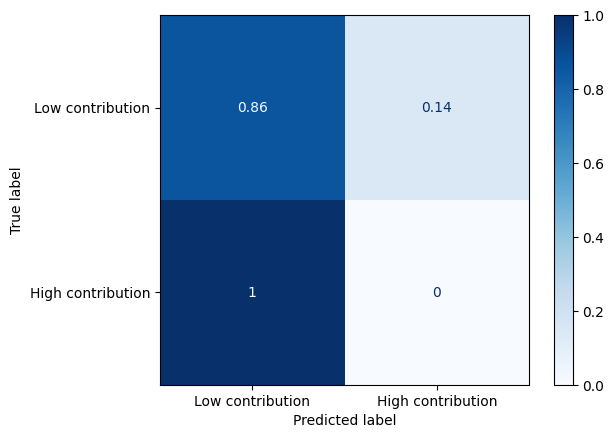

In [39]:
patch_accuracy = accuracy_score(reference_all_mlp_binary_1d, top_mlp_patch_binary_1d)
print(f"Causal tracing accuracy: {patch_accuracy}")

patch_precision_0, patch_precision_1 = precision_score(reference_all_mlp_binary_1d, top_mlp_patch_binary_1d, average=None)
print(f"Causal tracing precision: class 0 (low contribution) {patch_precision_0}, class 1 (high contribution) {patch_precision_1}")

patch_recall_0, patch_recall_1 = recall_score(reference_all_mlp_binary_1d, top_mlp_patch_binary_1d, average=None)
print(f"Causal tracing recall: class 0 (low contribution) {patch_recall_0}, class 1 (high contribution) {patch_recall_1}")

patch_jaccard_0, patch_jaccard_1 = jaccard_score(reference_all_mlp_binary_1d, top_mlp_patch_binary_1d, average=None)
print(f"Causal tracing Jaccard score: class 0 (low contribution) {patch_jaccard_0}, class 1 (high contribution) {patch_jaccard_1}")


patch_confusion_matrix = confusion_matrix(reference_all_mlp_binary_1d, top_mlp_patch_binary_1d, normalize="true")
patch_cm_display = ConfusionMatrixDisplay(patch_confusion_matrix, display_labels=["Low contribution", "High contribution"])
patch_cm_display.plot(cmap="Blues")
plt.show()

Integrated gradients and causal tracing seem to perform almost identically in terms of identifying known circuit neurons. Both methods identify true negatives and false negatives most of the time.

# Discrepancy analysis

We evaluate the discrepancy between the two methods, to investigate possible causes of the different attributions.

In [40]:
import json
from toy_transformers.brackets_datasets import BracketsDataset

# Get clean and corrupted datasets
with open("toy_transformers/brackets_data.json") as f:
    data_tuples = json.load(f)
    data_tuples = data_tuples[:8000]
    data = BracketsDataset(data_tuples)

clean_dataset = data.toks[data.isbal]
clean_is_balanced = torch.ones(clean_dataset.size(0))
corrupted_dataset = data.toks[~data.isbal]
corrupted_is_balanced = torch.zeros(corrupted_dataset.size(0))

print(clean_dataset.shape)

torch.Size([3647, 42])


In [41]:
from toy_transformers.toy_bracket_transformer import test_loaded_bracket_model_on_dataset

# Evaluate baseline performance on sample dataset

baseline_logits, baseline_performance = test_loaded_bracket_model_on_dataset(model, clean_dataset, clean_is_balanced)
print(baseline_performance)


Model got 3647 out of 3647 training examples correct!
tensor(1.)


In [42]:
_, corrupted_dataset_cache = model.run_with_cache(corrupted_dataset)

_, baseline_corrupted_performance = test_loaded_bracket_model_on_dataset(model, corrupted_dataset, corrupted_is_balanced)
print(baseline_corrupted_performance)


Model got 4353 out of 4353 training examples correct!
tensor(1.)


In [43]:
def ablate_neuron_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, set_neurons_to_keep: set):
    cached_activations = cache[hook.name].mean(dim=0) # Replace with mean value of activation samples
    n_neurons = activations.shape[2]
    layer = hook.layer()
    for idx in range(n_neurons):
        if (layer, idx) not in set_neurons_to_keep:
            activations[:, :, idx] = cached_activations[:, idx]
    return activations

def ablate_attn_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, set_heads_to_keep: set):
    cached_activations = cache[hook.name].mean(dim=0)
    n_heads = activations.shape[2]
    layer = hook.layer()
    for head_idx in range(n_heads):
        if (layer, head_idx) not in set_heads_to_keep:
            activations[:, :, head_idx, :] = cached_activations[:, head_idx, :]
    return activations

In [44]:
# Baseline comparison: ablating all MLP neurons and attention heads

model_ablate_all_hooks = []
for layer in range(model.cfg.n_layers):
    mlp_hook_point = get_act_name("mlp_out", layer)
    model_ablate_all_hooks.append((mlp_hook_point, lambda act, hook: ablate_neuron_hook(act, hook, corrupted_dataset_cache, set())))

    attn_hook_point = get_act_name("result", layer)
    model_ablate_all_hooks.append((attn_hook_point, lambda act, hook: ablate_attn_hook(act, hook, corrupted_dataset_cache, set())))
    
print(model_ablate_all_hooks)

with model.hooks(fwd_hooks=model_ablate_all_hooks):
    _, model_ablate_all_performance = test_loaded_bracket_model_on_dataset(model, clean_dataset, clean_is_balanced)
    print(model_ablate_all_performance)

[('blocks.0.hook_mlp_out', <function <lambda> at 0x18e2f56c0>), ('blocks.0.attn.hook_result', <function <lambda> at 0x18e2f5260>), ('blocks.1.hook_mlp_out', <function <lambda> at 0x18e2f5440>), ('blocks.1.attn.hook_result', <function <lambda> at 0x18e2f54e0>), ('blocks.2.hook_mlp_out', <function <lambda> at 0x18e2f5580>), ('blocks.2.attn.hook_result', <function <lambda> at 0x18e2f59e0>)]

Model got 0 out of 3647 training examples correct!
tensor(0.)


In [45]:
# Baseline comparison: ablating all MLP neurons

mlp_ablate_all_hooks = []
for layer in range(model.cfg.n_layers):
    hook_point = get_act_name("mlp_out", layer)
    mlp_ablate_all_hooks.append((hook_point, lambda act, hook: ablate_neuron_hook(act, hook, corrupted_dataset_cache, set())))

with model.hooks(fwd_hooks=mlp_ablate_all_hooks):
    _, mlp_ablate_all_performance = test_loaded_bracket_model_on_dataset(model, clean_dataset, clean_is_balanced)
    print(mlp_ablate_all_performance)



Model got 0 out of 3647 training examples correct!
tensor(0.)


In [46]:
# Baseline comparison: ablating all attention heads

attn_ablate_all_hooks = []
for layer in range(model.cfg.n_layers):
    attn_hook_point = get_act_name("result", layer)
    attn_ablate_all_hooks.append((attn_hook_point, lambda act, hook: ablate_attn_hook(act, hook, corrupted_dataset_cache, set())))

with model.hooks(fwd_hooks=attn_ablate_all_hooks):
    _, attn_ablate_all_performance = test_loaded_bracket_model_on_dataset(model, clean_dataset, clean_is_balanced)
    print(attn_ablate_all_performance)


Model got 0 out of 3647 training examples correct!
tensor(0.)


### Ablation studies for integrated gradients

In [47]:
# Evaluate faithfulness: when "unimportant" neurons and attention heads are ablated, performance should not be affected

ig_isolation_hooks = []
set_top_mlp_ig_indices = set([tuple(t.tolist()) for t in top_mlp_ig_indices])
print(f"Neurons to keep: {len(set_top_mlp_ig_indices)} out of {model.cfg.n_layers * model.cfg.d_mlp}")

set_ig_heads = set([(0,0), (1,0), (2,0), (2,1)])

for layer in range(model.cfg.n_layers):
    mlp_hook_point = get_act_name("mlp_out", layer)
    ig_isolation_hooks.append((mlp_hook_point, lambda act, hook: ablate_neuron_hook(act, hook, corrupted_dataset_cache, set_top_mlp_ig_indices)))

    attn_hook_point = get_act_name("result", layer)
    ig_isolation_hooks.append((attn_hook_point, lambda act, hook: ablate_attn_hook(act, hook, corrupted_dataset_cache, set_ig_heads)))

with model.hooks(fwd_hooks=ig_isolation_hooks):
    ig_isolated_logits, ig_isolated_performance = test_loaded_bracket_model_on_dataset(model, clean_dataset, clean_is_balanced)
    print(ig_isolated_performance)


Neurons to keep: 49 out of 168

Model got 3374 out of 3647 training examples correct!
tensor(0.9251)


In [48]:
# Get neurons to keep: complementary to neurons to keep

def get_complementary_neuron_indices(neuron_indices: torch.Tensor, mlp_shape: tuple):
    mask = torch.ones(mlp_shape)
    for idx in neuron_indices:
        layer_idx, neuron_idx = tuple(idx)
        if layer_idx < mlp_shape[0] and neuron_idx < mlp_shape[1]:
            mask[layer_idx, neuron_idx] = 0.0
    complementary_indices = torch.nonzero(mask)
    return complementary_indices

# Evaluate completeness: when "important" neurons are ablated, performance should be affected

mlp_ig_excluded_indices = get_complementary_neuron_indices(top_mlp_ig_indices, (model.cfg.n_layers, model.cfg.d_mlp))
set_mlp_ig_excluded_indices = set([tuple(t.tolist()) for t in mlp_ig_excluded_indices])
print(f"Neurons to keep: {len(set_mlp_ig_excluded_indices)} out of {model.cfg.n_layers * model.cfg.d_mlp}")

set_ig_excluded_heads = [(0,1), (1,1)]

ig_ablation_hooks = []
for layer in range(model.cfg.n_layers):
    hook_point = get_act_name("mlp_out", layer)
    ig_ablation_hooks.append((hook_point, lambda act, hook: ablate_neuron_hook(act, hook, corrupted_dataset_cache, set_neurons_to_keep=set_mlp_ig_excluded_indices)))

    attn_hook_point = get_act_name("result", layer)
    ig_ablation_hooks.append((attn_hook_point, lambda act, hook: ablate_attn_hook(act, hook, corrupted_dataset_cache, set_ig_excluded_heads)))


with model.hooks(fwd_hooks=ig_ablation_hooks):
    _, ig_ablated_performance = test_loaded_bracket_model_on_dataset(model, clean_dataset, clean_is_balanced)
    print(ig_ablated_performance)

Neurons to keep: 119 out of 168

Model got 0 out of 3647 training examples correct!
tensor(0.)


### Ablation studies on causal tracing

In [49]:
# Evaluate faithfulness: when "unimportant" neurons and attention heads are ablated, performance should not be affected

patch_isolation_hooks = []
set_top_mlp_patch_indices = set([tuple(t.tolist()) for t in top_mlp_patch_indices])
print(f"Neurons to keep: {len(set_top_mlp_patch_indices)} out of {model.cfg.n_layers * model.cfg.d_mlp}")

set_patch_heads = set([(0,0), (1,0), (2,0), (2,1)])

for layer in range(model.cfg.n_layers):
    mlp_hook_point = get_act_name("mlp_out", layer)
    patch_isolation_hooks.append((mlp_hook_point, lambda act, hook: ablate_neuron_hook(act, hook, corrupted_dataset_cache, set_top_mlp_patch_indices)))

    attn_hook_point = get_act_name("result", layer)
    patch_isolation_hooks.append((attn_hook_point, lambda act, hook: ablate_attn_hook(act, hook, corrupted_dataset_cache, set_patch_heads)))

with model.hooks(fwd_hooks=patch_isolation_hooks):
    patch_isolated_logits, patch_isolated_performance = test_loaded_bracket_model_on_dataset(model, clean_dataset, clean_is_balanced)
    print(patch_isolated_performance)


Neurons to keep: 12 out of 168

Model got 312 out of 3647 training examples correct!
tensor(0.0855)


In [50]:
# Evaluate completeness: when "important" neurons are ablated, performance should be affected

patch_ig_excluded_indices = get_complementary_neuron_indices(top_mlp_patch_indices, (model.cfg.n_layers, model.cfg.d_mlp))
set_mlp_patch_excluded_indices = set([tuple(t.tolist()) for t in patch_ig_excluded_indices])
print(f"Neurons to keep: {len(set_mlp_patch_excluded_indices)} out of {model.cfg.n_layers * model.cfg.d_mlp}")

set_patch_excluded_heads = [(0,1), (1,1)]

patch_ablation_hooks = []
for layer in range(model.cfg.n_layers):
    hook_point = get_act_name("mlp_out", layer)
    patch_ablation_hooks.append((hook_point, lambda act, hook: ablate_neuron_hook(act, hook, corrupted_dataset_cache, set_neurons_to_keep=set_mlp_patch_excluded_indices)))

    attn_hook_point = get_act_name("result", layer)
    patch_ablation_hooks.append((attn_hook_point, lambda act, hook: ablate_attn_hook(act, hook, corrupted_dataset_cache, set_patch_excluded_heads)))


with model.hooks(fwd_hooks=patch_ablation_hooks):
    _, patch_ablated_performance = test_loaded_bracket_model_on_dataset(model, clean_dataset, clean_is_balanced)
    print(patch_ablated_performance)

Neurons to keep: 156 out of 168

Model got 0 out of 3647 training examples correct!
tensor(0.)


### Analysis of ablation studies

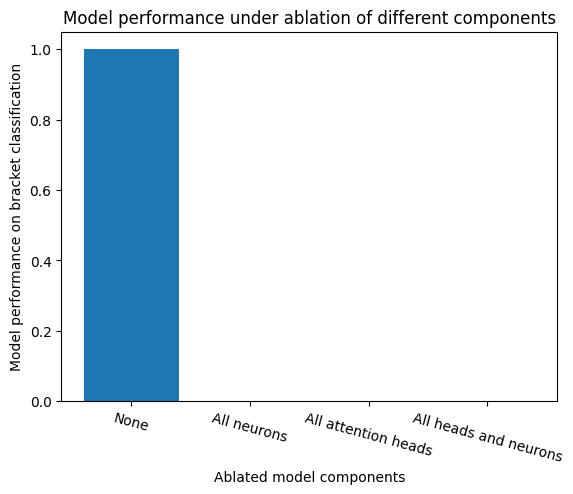

In [51]:
plt.title("Model performance under ablation of different components")
plt.xlabel("Ablated model components")
plt.ylabel("Model performance on bracket classification")
plt.bar(
    ["None", "All neurons", "All attention heads", "All heads and neurons"],
    [baseline_performance, mlp_ablate_all_performance, attn_ablate_all_performance, model_ablate_all_performance]
)
plt.xticks(rotation=-15)
plt.show()

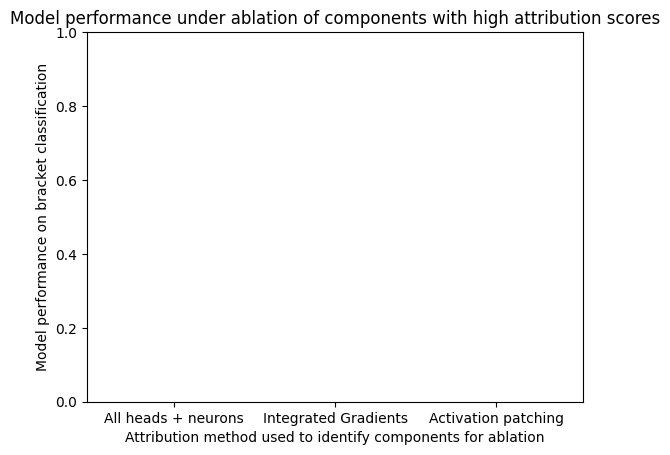

In [52]:
plt.title("Model performance under ablation of components with high attribution scores")
plt.xlabel("Attribution method used to identify components for ablation")
plt.ylabel("Model performance on bracket classification")
plt.bar(
    ["All heads + neurons", "Integrated Gradients", "Activation patching"],
    [model_ablate_all_performance, ig_ablated_performance, patch_ablated_performance],
    color=['grey', 'tab:blue', 'tab:blue']
)
plt.ylim(0, 1)
plt.show()

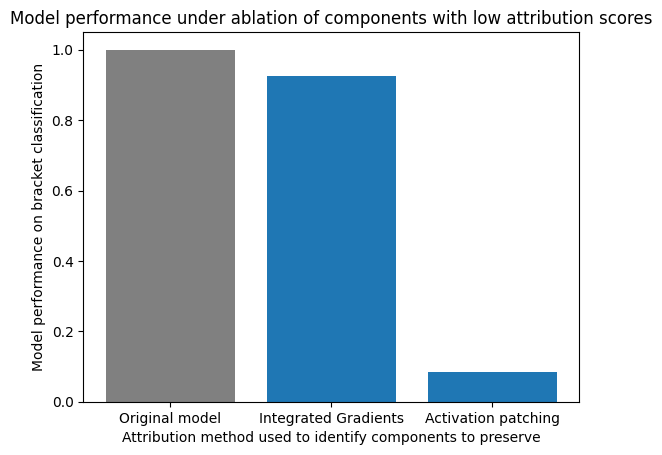

In [53]:
plt.title("Model performance under ablation of components with low attribution scores")
plt.xlabel("Attribution method used to identify components to preserve")
plt.ylabel("Model performance on bracket classification")
plt.bar(
    ["Original model", "Integrated Gradients", "Activation patching"],
    [baseline_performance, ig_isolated_performance, patch_isolated_performance],
    color=['grey', 'tab:blue', 'tab:blue']
)
plt.show()

# Knowledge localisation

We identify which components localise information for specific tokens, and evaluate the effectiveness of steering for each method.

In [54]:
def integrated_gradient_attribution(input_string: str):
    # Gradient attribution for neurons in MLP layers
    mlp_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
    # Gradient attribution for attention heads
    attn_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

    input = tokenizer.tokenize(input_string)
    mask = np.isin(input, [tokenizer.START_TOKEN, tokenizer.END_TOKEN])
    baseline = input * mask + tokenizer.PAD_TOKEN * (1 - mask)

    for layer in range(model.cfg.n_layers):
        # Gradient attribution on heads
        hook_name = get_act_name("result", layer)
        target_layer = model.hook_dict[hook_name]
        attributions = compute_layer_to_output_attributions(input, target_layer, baseline) # shape [1, seq_len, d_head, d_model]
        # Calculate attribution score based on mean over each embedding, for each token
        per_token_score = attributions.mean(dim=3)
        score = per_token_score.mean(dim=1)
        attn_results[layer] = score

        # Gradient attribution on MLP neurons
        target_layer = model.blocks[layer].hook_mlp_out
        attributions = compute_layer_to_output_attributions(input, target_layer, baseline) # shape [1, seq_len, d_model]
        score = attributions.mean(dim=1)
        mlp_results[layer] = score

    return mlp_results, attn_results

In [55]:
mlp_open_results, attn_open_results = integrated_gradient_attribution("((")
mlp_closed_results, attn_closed_results = integrated_gradient_attribution("))")


Error (delta) for blocks.0.attn.hook_result attribution: 0.0013695928500965238

Error (delta) for blocks.0.hook_mlp_out attribution: -0.0001100528534152545

Error (delta) for blocks.1.attn.hook_result attribution: 0.0001736992271617055

Error (delta) for blocks.1.hook_mlp_out attribution: -0.0010857651941478252

Error (delta) for blocks.2.attn.hook_result attribution: -0.013093475252389908

Error (delta) for blocks.2.hook_mlp_out attribution: -0.00012520691961981356

Error (delta) for blocks.0.attn.hook_result attribution: 0.0013547124108299613

Error (delta) for blocks.0.hook_mlp_out attribution: -0.000110413740912918

Error (delta) for blocks.1.attn.hook_result attribution: -0.0004306236805859953

Error (delta) for blocks.1.hook_mlp_out attribution: -0.00031769595807418227

Error (delta) for blocks.2.attn.hook_result attribution: 0.001997644081711769

Error (delta) for blocks.2.hook_mlp_out attribution: -8.628690557088703e-05


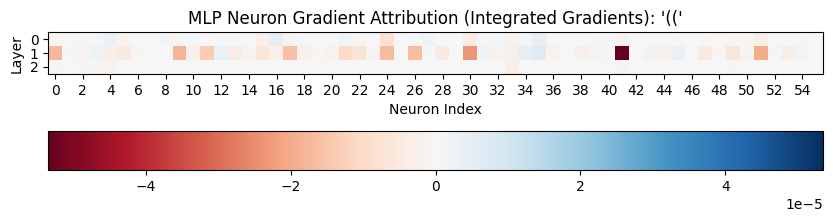

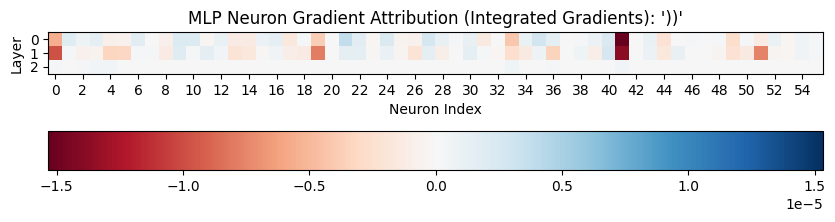

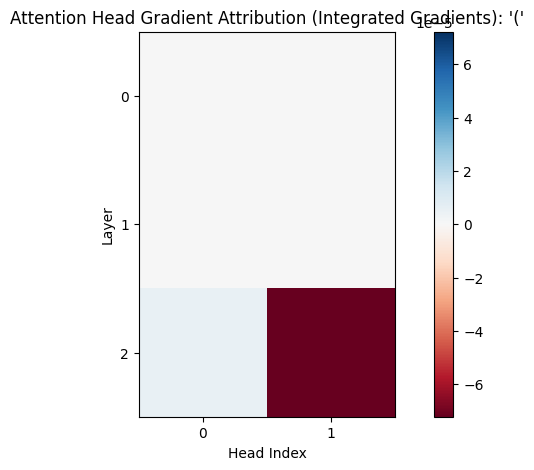

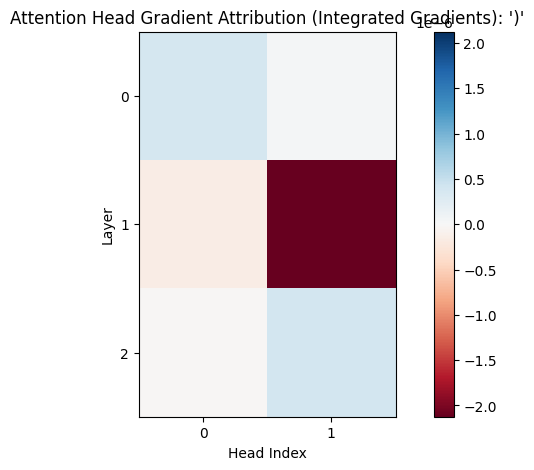

In [56]:
bound = max(torch.max(mlp_open_results), abs(torch.min(mlp_open_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_open_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients): '(('")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

bound = max(torch.max(mlp_closed_results), abs(torch.min(mlp_closed_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_closed_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients): '))'")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()


bound = max(torch.max(attn_open_results), abs(torch.min(attn_open_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_open_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Integrated Gradients): '('")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

bound = max(torch.max(attn_closed_results), abs(torch.min(attn_closed_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_closed_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Integrated Gradients): ')'")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

# Circuit construction

We construct a circuit for each attribution method, by removing all unimportant components and their connections.

We investigate the completeness, faithfulness and minimality of the constructed circuits.